# Final Project For BIOL 8803 Binary Classification of Moth Feeding

In [2]:
## Import dependencies
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

import xgboost as xgb
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.inspection import permutation_importance
import shap 
from tqdm import tqdm 
from utils import *

Lets Load in the Data

In [ ]:
load_and_preprocess = False
if load_and_preprocess:
    d = pd.read_csv("highdimensionbigdata.csv")
    ## Only using Count and 1st Phase for rn to avoid sparseness 
    col = ["moth", "wb", "trial"]
    col.extend([n for n in d.columns if "count" in n])
    col.extend([n for n in d.columns if "1" in n])
    df = d[col]
    df.loc[:,'trial'] = df.loc[:,'trial'].replace({'pre': 0, 'post': 1})
    nona = df.copy()
    nona.dropna(inplace=True)
    nona.to_csv("23dimcountime.csv", index=False)
else:
    nona = pd.read_csv("23dimcountime.csv")

Define the Featueres we Want

In [6]:
features = [n for n in nona.columns if n not in ["wb","trial","moth"]]

Testing The XGBoost Model

In [7]:
model, X_test, y_test, importance,auc = train_xgboost_classifier(
    df=nona,
    target_col='trial',
    feature_cols=features,
    printout = True
)

Pass `evals` as keyword args.
[16:01:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.




Model Performance:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       130
         1.0       0.99      0.98      0.99       136

    accuracy                           0.98       266
   macro avg       0.98      0.99      0.98       266
weighted avg       0.99      0.98      0.98       266


ROC AUC Score: 0.9995475113122172


Sweep Through Learning Rate and Max Depth To See Hyper Parameter Performance

In [11]:
depths = np.arange(1,11,1)
rates = np.round(np.arange(0.1,1.1,.1),decimals=1)


param_sweep = np.array(np.zeros((len(depths),len(rates))))
for i,dep in enumerate(depths):
    for j, r in enumerate(rates):
        tmp = []
        for k in range(10):
            model, X_test, y_test, importance,auc = train_xgboost_classifier(
                df=nona,
                target_col='trial',
                feature_cols=features,
                printout = False,
                learning_rate= r,
                max_depth=j
                )
            tmp.append(auc)
        param_sweep[i,j] = np.mean(tmp)

Pass `evals` as keyword args.
[16:42:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:42:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:42:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:42:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:42:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyw

Plot the Results!

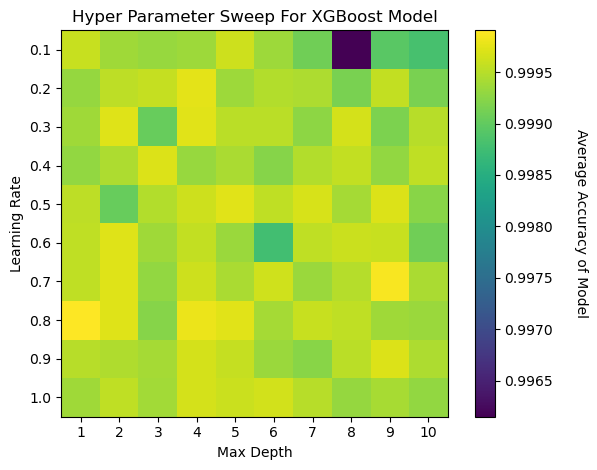

In [12]:
fig,ax = plt.subplots()
cax = ax.imshow(param_sweep,cmap='viridis',interpolation='nearest')
ax.set_xticks(ticks=np.arange(10),labels=depths.astype(str))
ax.set_yticks(ticks=np.arange(10),labels=rates.astype(str))
# ax.set_colorbar()
ax.set_xlabel("Max Depth")
ax.set_ylabel("Learning Rate")
ax.set_title("Hyper Parameter Sweep For XGBoost Model")
cbar = fig.colorbar(cax,ax=ax)
cbar.set_label("Average Accuracy of Model",rotation=270, labelpad=25)
plt.tight_layout()
plt.show()

It All Looks Fine, Lets keep learning_rate at 0.1 and depth at 4 from the first model

Now lets look at the importance scores over many many runs to see if there are patterns

In [8]:
n_runs = 100
all_runs = []
for i in range(n_runs):
    _,_,_,importance,auc = train_xgboost_classifier(
    df=nona,
    target_col='trial',
    feature_cols=features,
    printout = False
    ) 

    dic = importance.set_index('feature')['importance'].to_dict()

    dic["iteration"] = i 
    dic["accuracy"] = auc 

    all_runs.append(dic)

results = pd.DataFrame(all_runs)



Pass `evals` as keyword args.
[16:01:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:01:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:01:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:01:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:01:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyw



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
FixedFormatter should only be used together with FixedLocator


The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
FixedFormatter should only be used together with FixedLocator


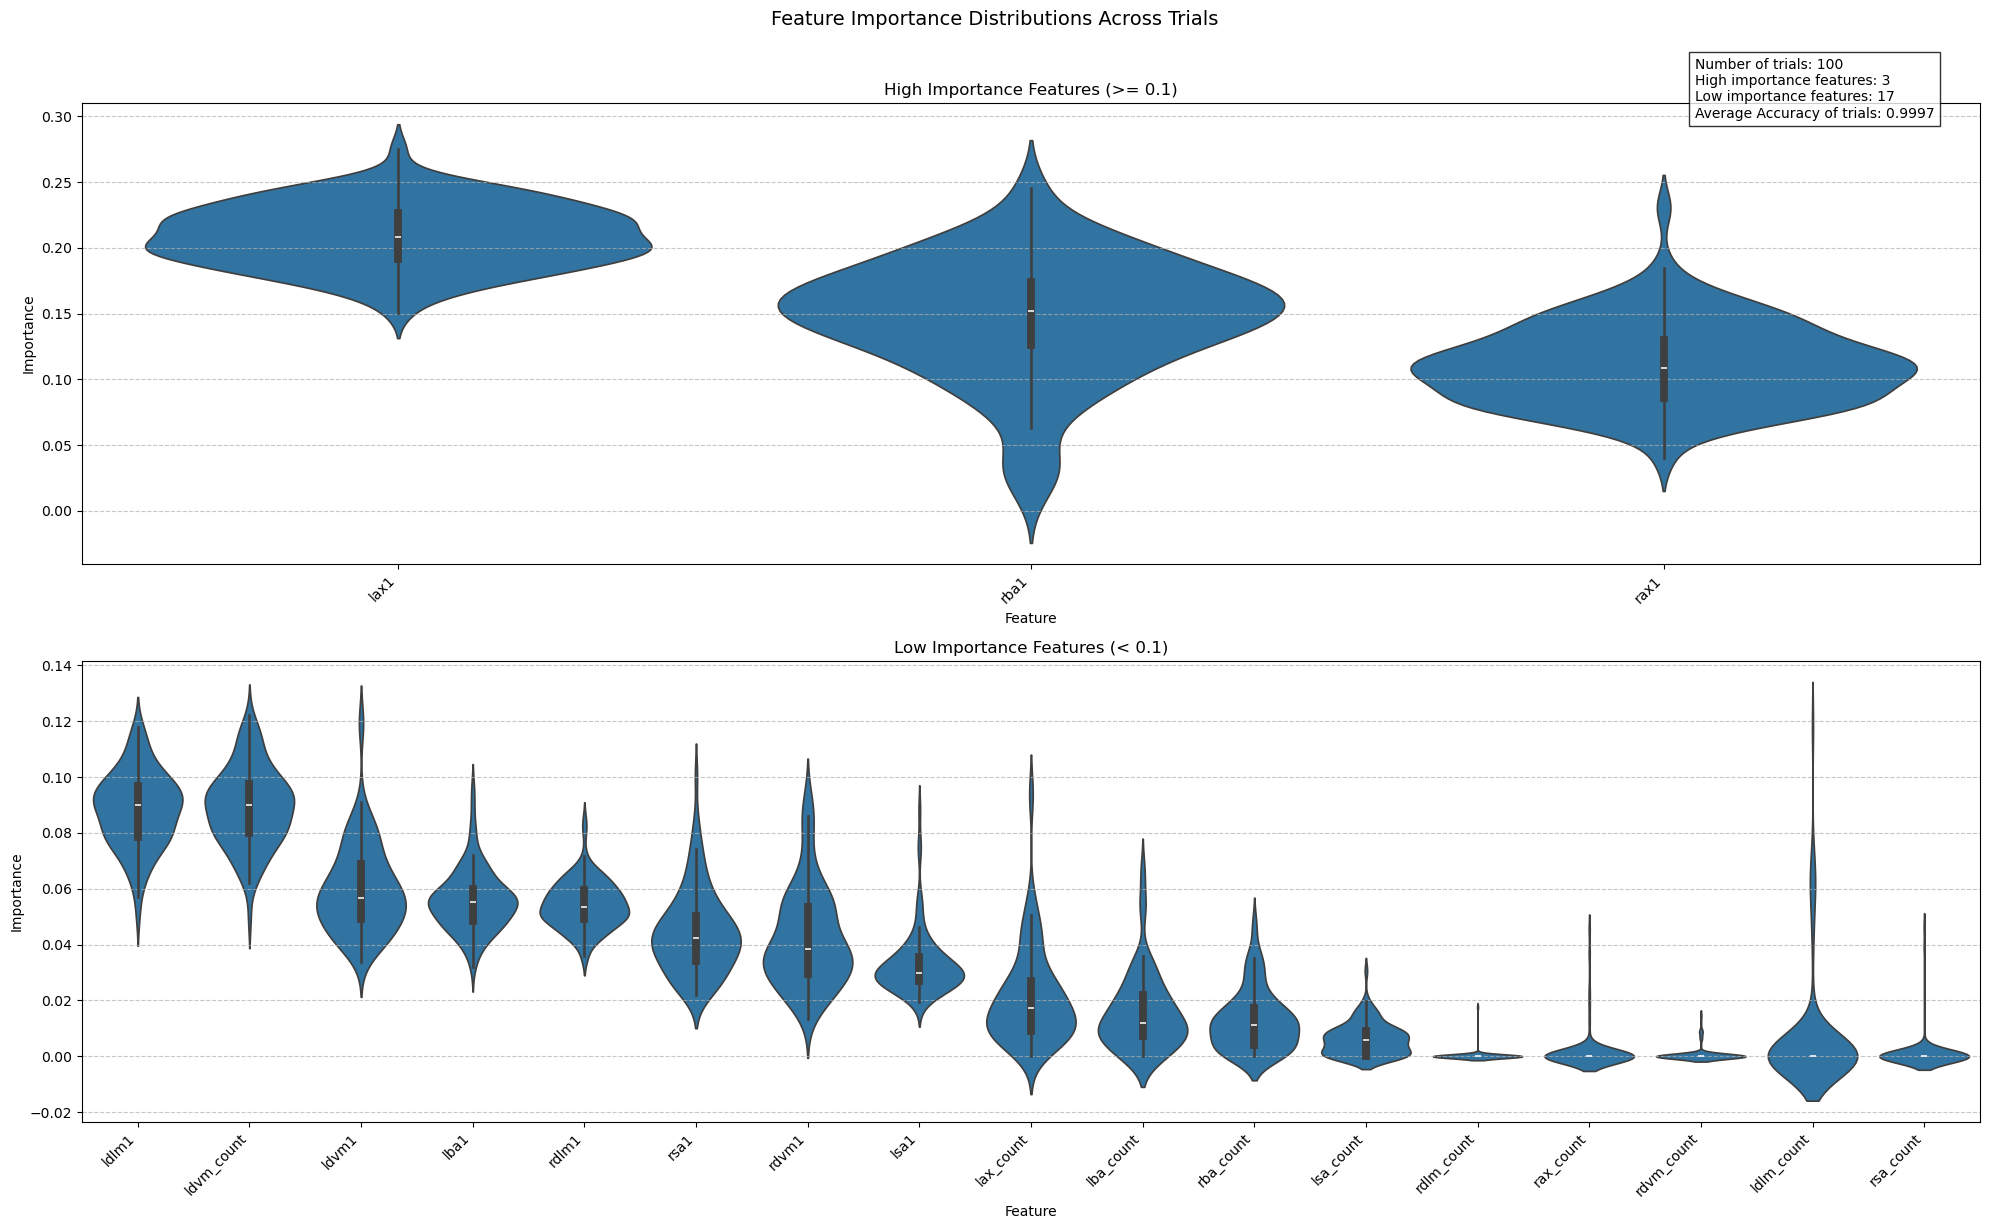

In [10]:
fs = results.copy()
fs.drop(columns=["accuracy","iteration"],inplace=True)
fig = plot_feature_importance_split(
    results_df=results,
    importance_threshold=0.1,
    figsize=(20, 12)
)
fig.savefig("Figs/FeatureImportanceBoost.png",bbox_inches='tight')

What if I looked At only the Left Side to Help reduce the Dimensionality, Bilateral Symmetry Assuption Should probably Hold? 

In [11]:
tm = [mus for mus in features if 'l' in mus]
left_side = [mus for mus in tm if 'r' not in mus]

In [12]:
n_runs = 100
all_runs = []
for i in range(n_runs):
    _,_,_,importance,auc = train_xgboost_classifier(
    df=nona,
    target_col='trial',
    feature_cols=left_side,
    printout = False
    ) 

    dic = importance.set_index('feature')['importance'].to_dict()

    dic["iteration"] = i 
    dic["accuracy"] = auc 

    all_runs.append(dic)

results = pd.DataFrame(all_runs)


Pass `evals` as keyword args.
[16:02:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:02:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:02:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:02:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyword args.
[16:02:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

Pass `evals` as keyw



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
FixedFormatter should only be used together with FixedLocator


The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
FixedFormatter should only be used together with FixedLocator


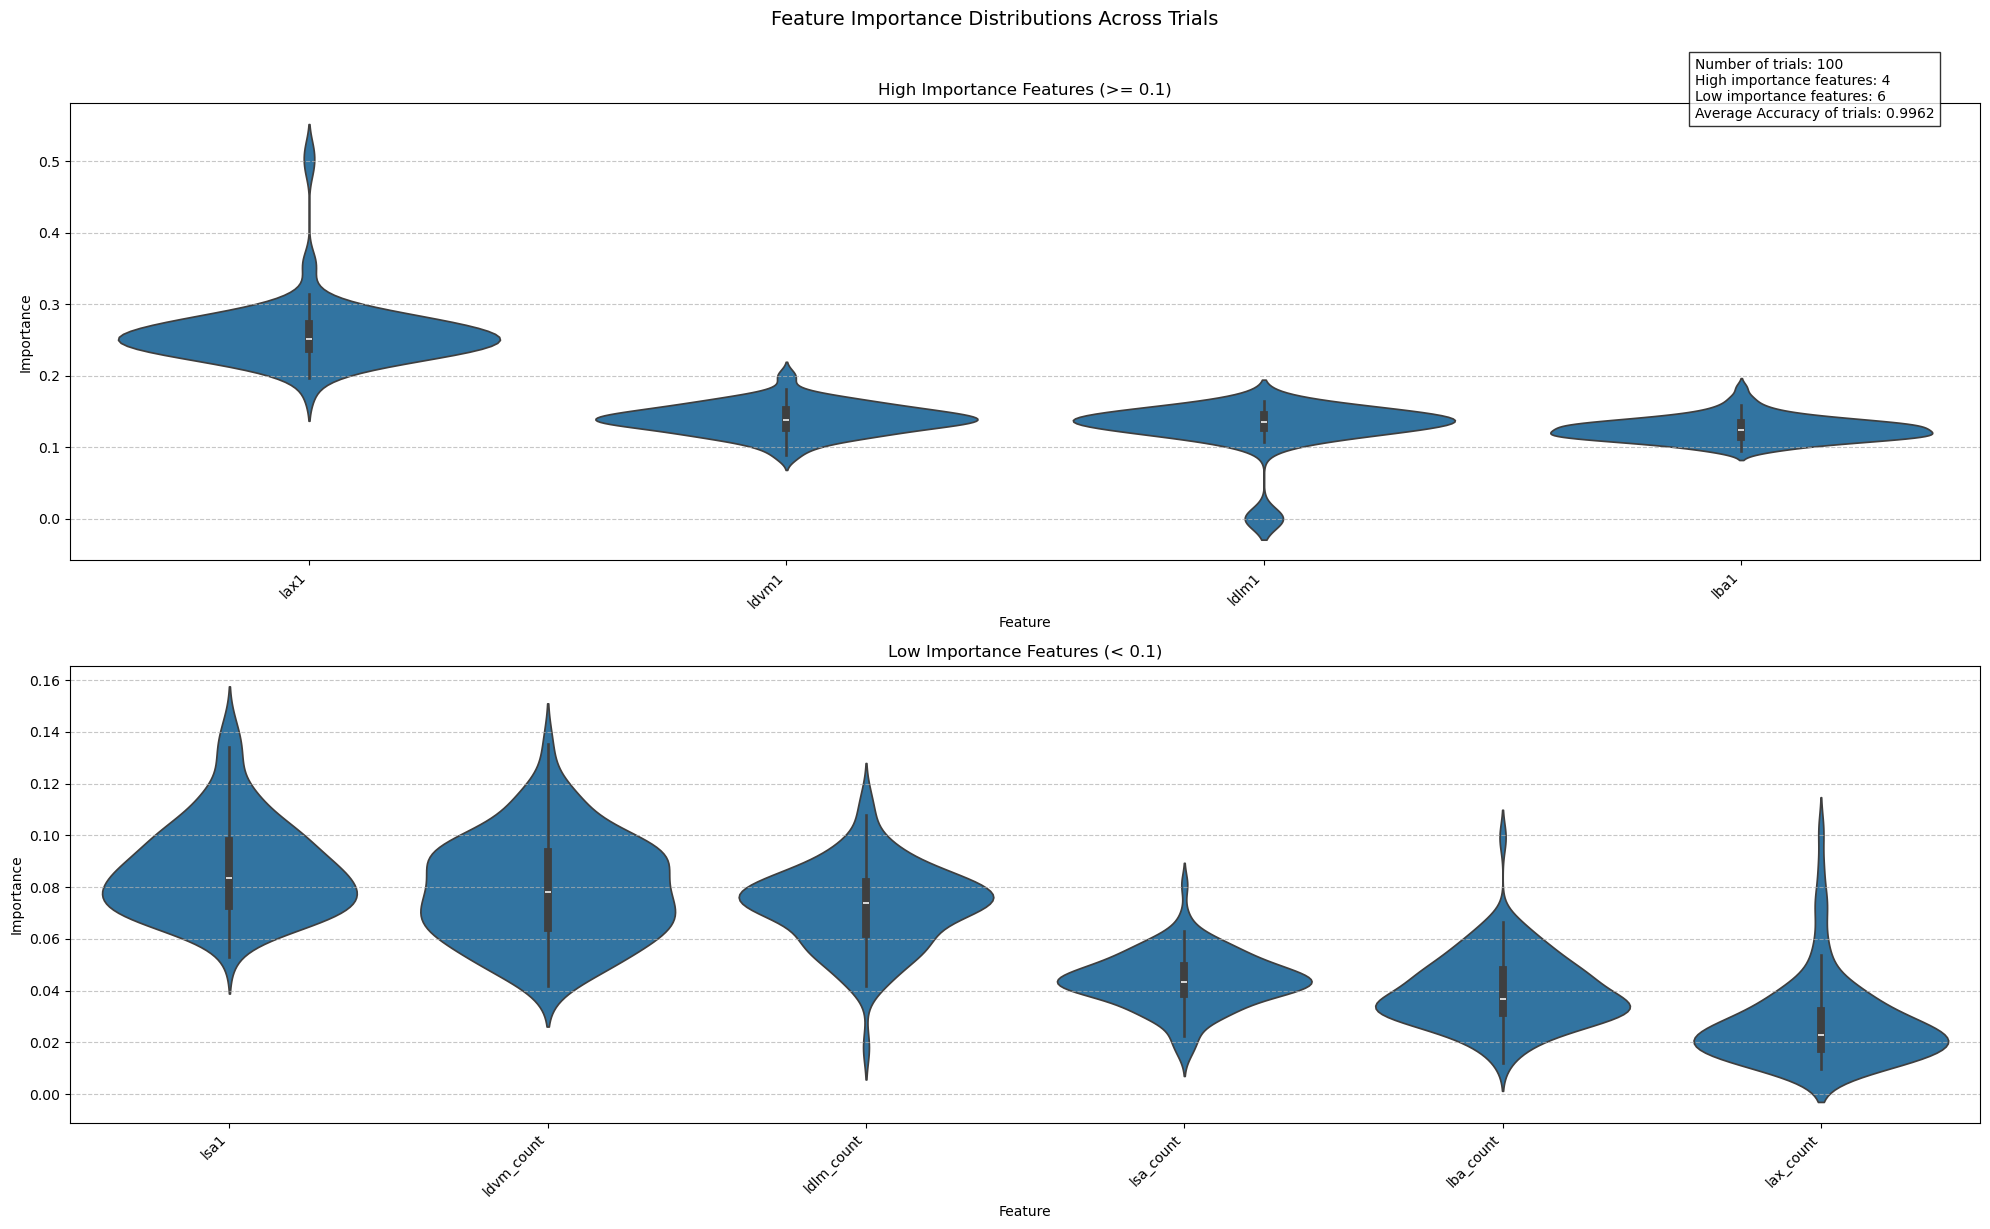

In [14]:
fig = plot_feature_importance_split(
    results_df=results,
    importance_threshold=0.10
,   figsize=(20, 12)
)
fig.savefig("Figs/FeatureImportanceBoostLeftSide.png",bbox_inches='tight')

Now, What pairs of muscles (Left and Right side) Make the Best Model?

In [15]:
musnames = ["ax","ba","sa","dvm","dlm"]
full_names = {"ax":"Axillary","ba":"Basalar","sa":"Subalar","dvm":"DVM","dlm":"DLM"}
n_runs = 100

all_mus = {}
for mus in musnames:
    print(f"Now Doing {mus}")
    all_runs = []
    subfeat = [m for m in features if mus in m ]
    for i in tqdm(range(n_runs)):
        _,_,_,importance,auc = train_xgboost_classifier(
        df=nona,
        target_col='trial',
        feature_cols=subfeat,
        printout = False
        ) 

        all_runs.append(auc)
    all_mus[full_names[mus]] = all_runs

res = pd.DataFrame(all_mus)

Now Doing ax


  0%|          | 0/100 [00:00<?, ?it/s]Pass `evals` as keyword args.
[16:04:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  1%|          | 1/100 [00:00<00:19,  5.03it/s]Pass `evals` as keyword args.
[16:04:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  2%|▏         | 2/100 [00:00<00:19,  4.91it/s]Pass `evals` as keyword args.
[16:04:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  3%|▎         | 3/100 [00:00<00:19,  5.01it/s]Pass `evals` as keyword args.
[16:04:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  4%|▍         | 4/100 [00:00<00:19,

Now Doing ba


  0%|          | 0/100 [00:00<?, ?it/s]Pass `evals` as keyword args.
[16:04:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  1%|          | 1/100 [00:00<00:23,  4.23it/s]Pass `evals` as keyword args.
[16:04:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  2%|▏         | 2/100 [00:00<00:20,  4.73it/s]Pass `evals` as keyword args.
[16:04:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  3%|▎         | 3/100 [00:00<00:20,  4.65it/s]Pass `evals` as keyword args.
[16:04:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  4%|▍         | 4/100 [00:00<00:20,

Now Doing sa


  0%|          | 0/100 [00:00<?, ?it/s]Pass `evals` as keyword args.
[16:04:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  1%|          | 1/100 [00:00<00:23,  4.18it/s]Pass `evals` as keyword args.
[16:04:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  2%|▏         | 2/100 [00:00<00:23,  4.21it/s]Pass `evals` as keyword args.
[16:04:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  3%|▎         | 3/100 [00:00<00:22,  4.41it/s]Pass `evals` as keyword args.
[16:04:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  4%|▍         | 4/100 [00:00<00:22,

Now Doing dvm


  0%|          | 0/100 [00:00<?, ?it/s]Pass `evals` as keyword args.
[16:05:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  1%|          | 1/100 [00:00<00:24,  3.98it/s]Pass `evals` as keyword args.
[16:05:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  2%|▏         | 2/100 [00:00<00:23,  4.19it/s]Pass `evals` as keyword args.
[16:05:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  3%|▎         | 3/100 [00:00<00:22,  4.28it/s]Pass `evals` as keyword args.
[16:05:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  4%|▍         | 4/100 [00:00<00:21,

Now Doing dlm


  0%|          | 0/100 [00:00<?, ?it/s]Pass `evals` as keyword args.
[16:05:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  1%|          | 1/100 [00:00<00:14,  6.70it/s]Pass `evals` as keyword args.
[16:05:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  2%|▏         | 2/100 [00:00<00:16,  5.86it/s]Pass `evals` as keyword args.
[16:05:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  3%|▎         | 3/100 [00:00<00:17,  5.47it/s]Pass `evals` as keyword args.
[16:05:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "evals", "silent" } are not used.

  4%|▍         | 4/100 [00:00<00:17,

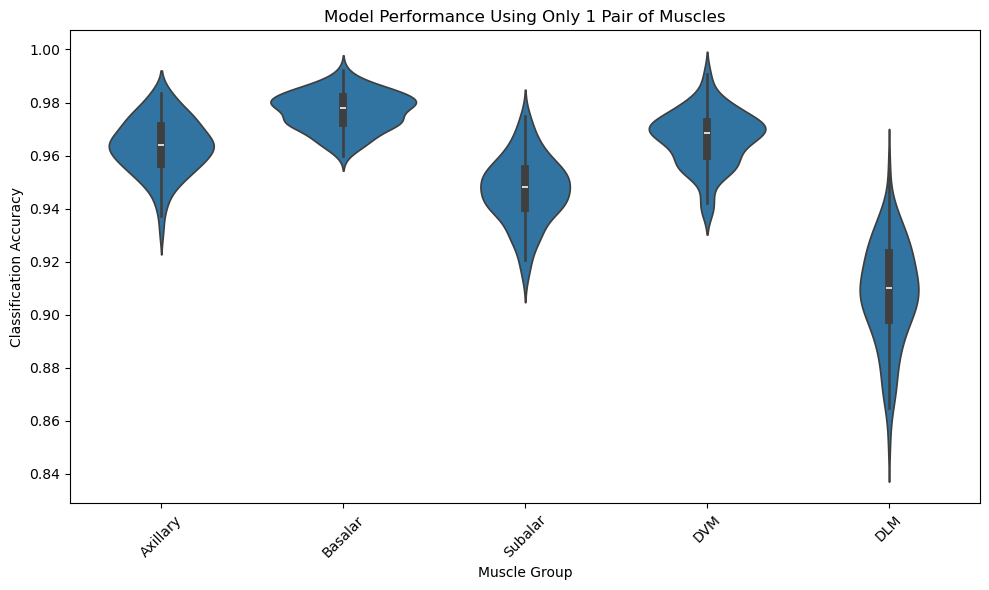

In [16]:
meled = res.melt(var_name = 'Column',value_name = "Value")
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.violinplot(data=meled,x='Column',y='Value')
plt.xticks(rotation = 45)
ax.set_xlabel("Muscle Group")
ax.set_ylabel("Classification Accuracy")
ax.set_title("Model Performance Using Only 1 Pair of Muscles")

plt.tight_layout()
plt.show()
fig.savefig("Figs/BoostPerformanceByMusclePair.png",bbox_inches='tight')

Lets Look At Feature Importance

In [17]:
X = nona.drop(columns=['trial',"wb","moth"])

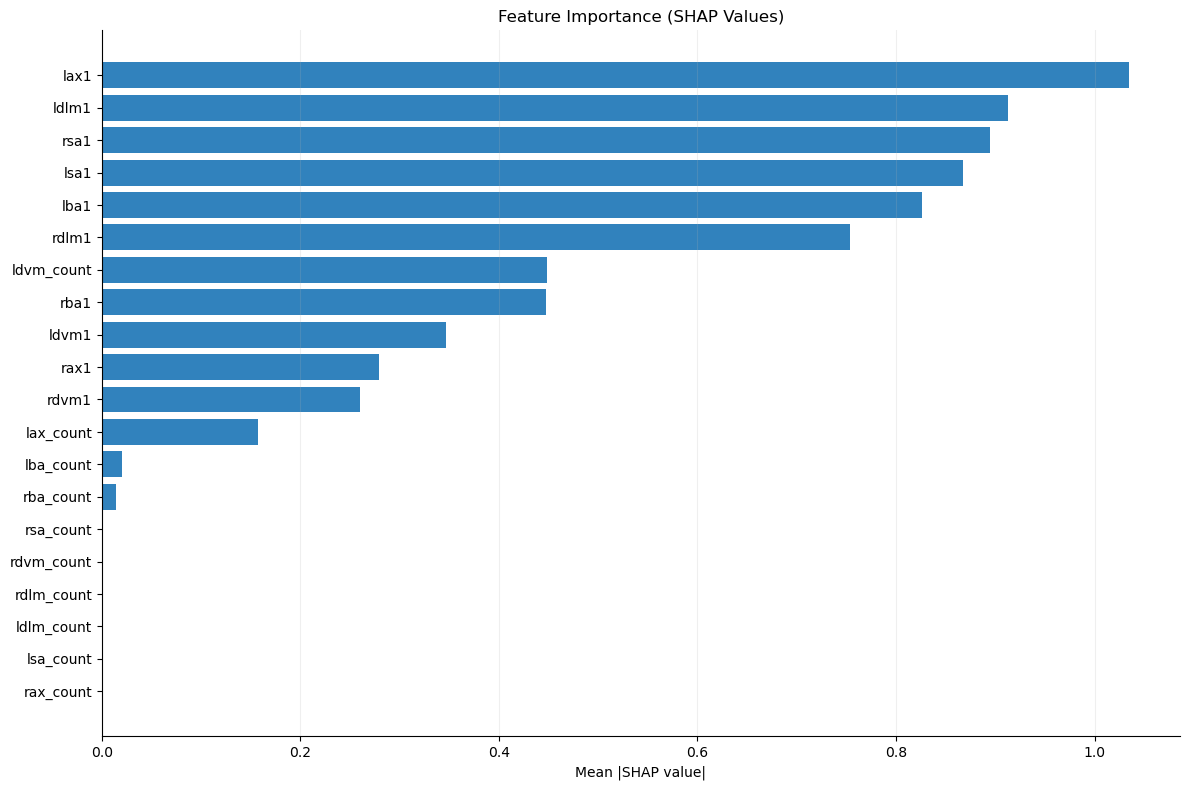

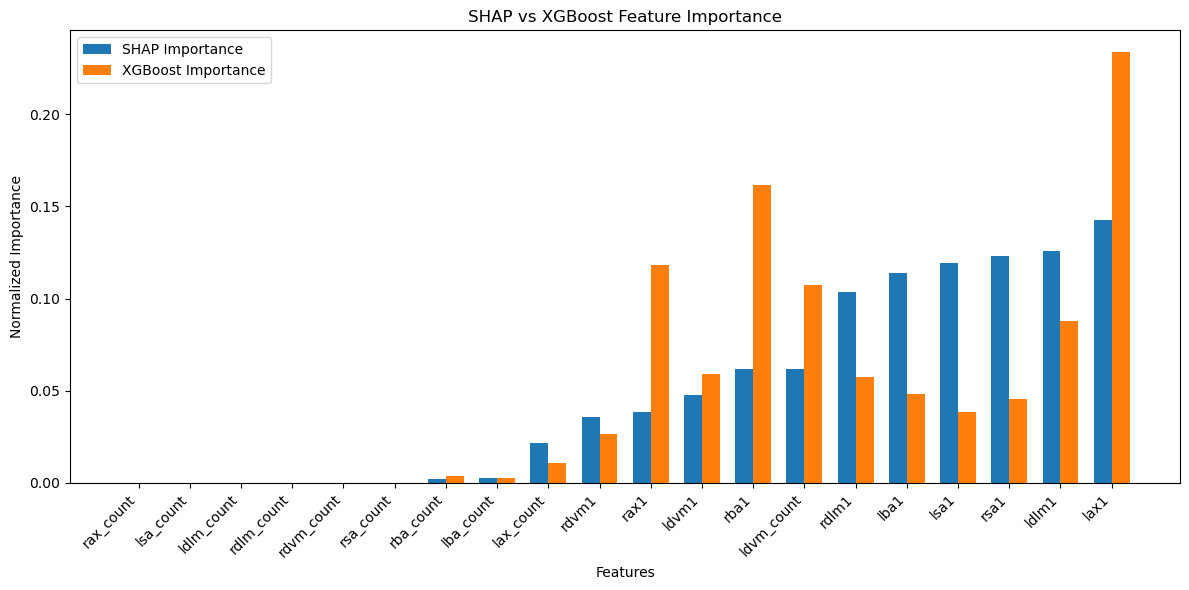

In [18]:
vals, shapdf, featimp = calculate_treeshap(model,X,features)

# Now We Can Move to A SVM Both Linear and by RBF 

Lets look Linear SVM First

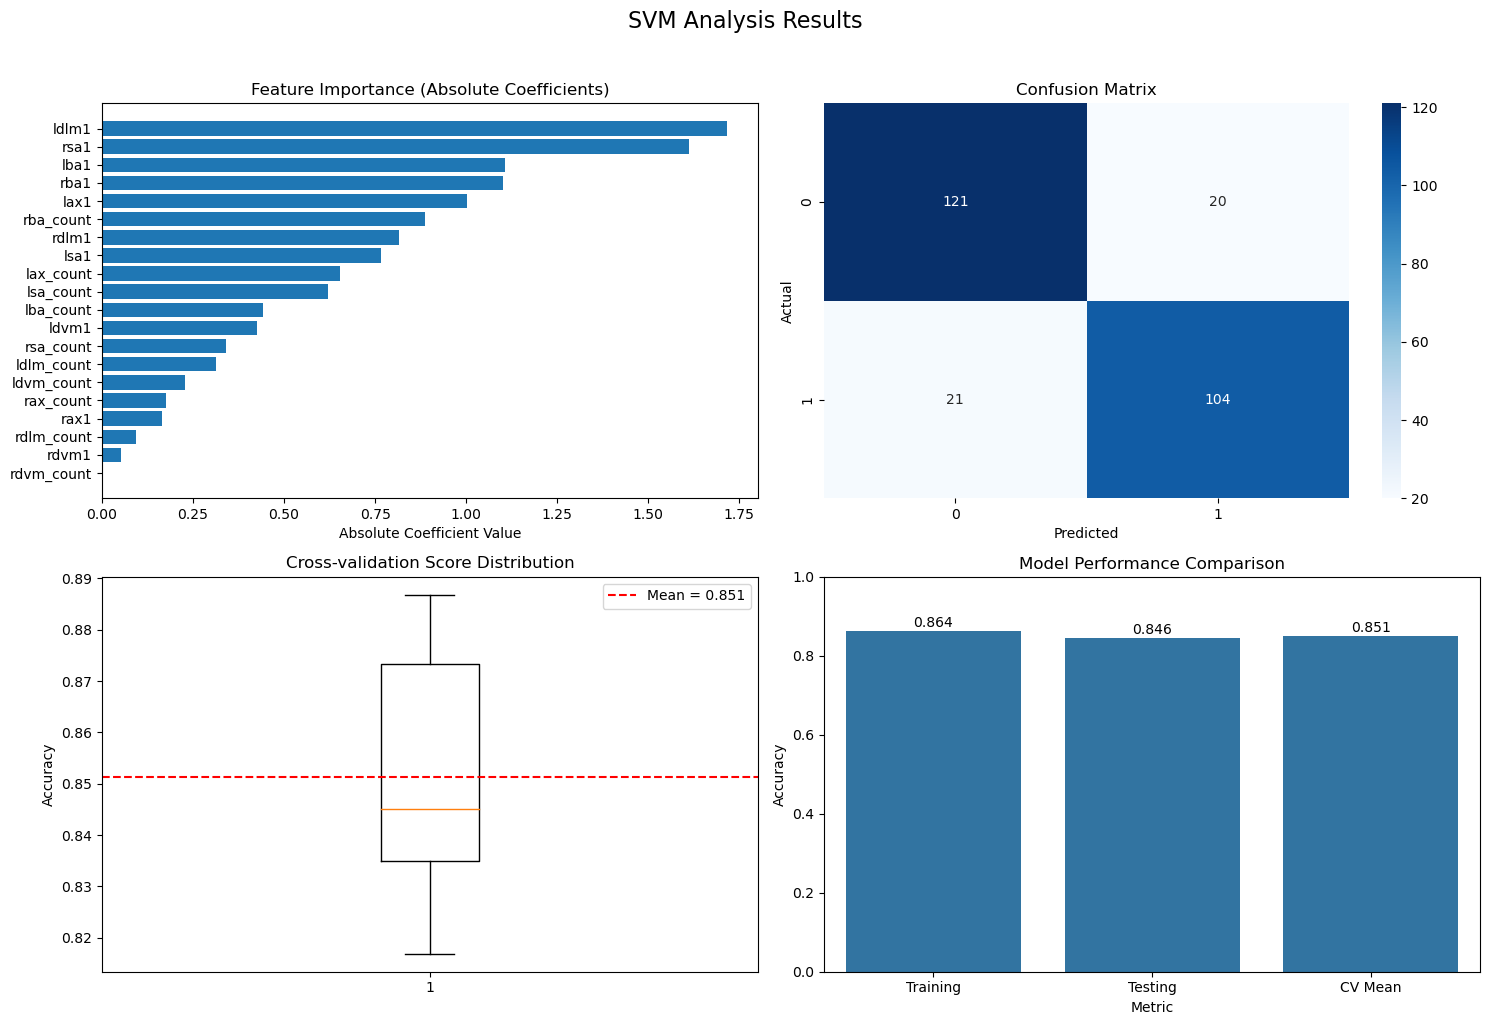

In [19]:
reslin = run_svm_analysis(nona,features,"trial",kernel='linear')
fig = plot_svm_results(reslin,features)


RBF?

In [20]:
resrbf = run_svm_analysis(nona,features,"trial",kernel="rbf")
print(f"The Mean CV Score is: {np.round(np.mean(resrbf['cv_scores']),decimals=4)}")

The Mean CV Score is: 0.9661


What impact does the Hyper Parameter C Have on Accuracy For both models? 

In [31]:
cs = np.arange(1,11)
c_lin = []
c_rbf = []
for c in cs:
    tmplin = []
    tmprbf = []
    for i in range(10):
        rlin = run_svm_analysis(nona,features,"trial",kernel='linear',C=c)
        rrbf = run_svm_analysis(nona,features,"trial",kernel='rbf',C=c)

        tmplin.append(np.mean(rlin["cv_scores"]))
        tmprbf.append(np.mean(rrbf["cv_scores"]))
    c_lin.append(tmplin)
    c_rbf.append(tmprbf)



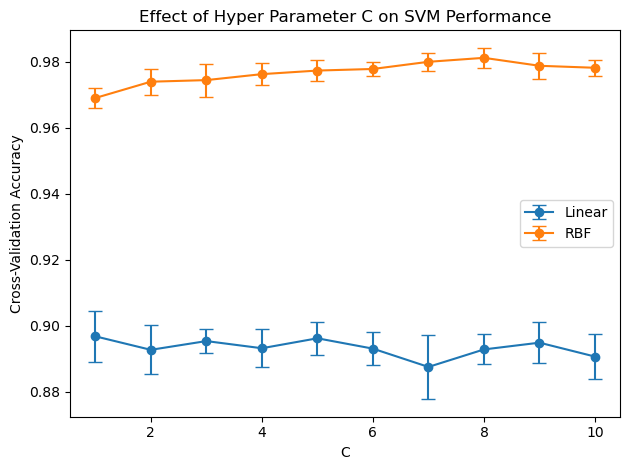

In [32]:
mean_lin = np.mean(c_lin,axis=1)
std_lin = np.std(c_lin,axis=1)
mean_rbf = np.mean(c_rbf,axis=1)
std_rbf = np.std(c_rbf,axis=1)


plt.errorbar(cs, mean_lin, yerr=std_lin, label="Linear", fmt='-o', capsize=5)
plt.errorbar(cs, mean_rbf, yerr=std_rbf, label="RBF", fmt='-o', capsize=5)

plt.xlabel("C")
plt.ylabel("Cross-Validation Accuracy")
plt.legend()
plt.title("Effect of Hyper Parameter C on SVM Performance")
plt.tight_layout()
# Show the plot
plt.show()

Lets Use C=8 Moving Forward

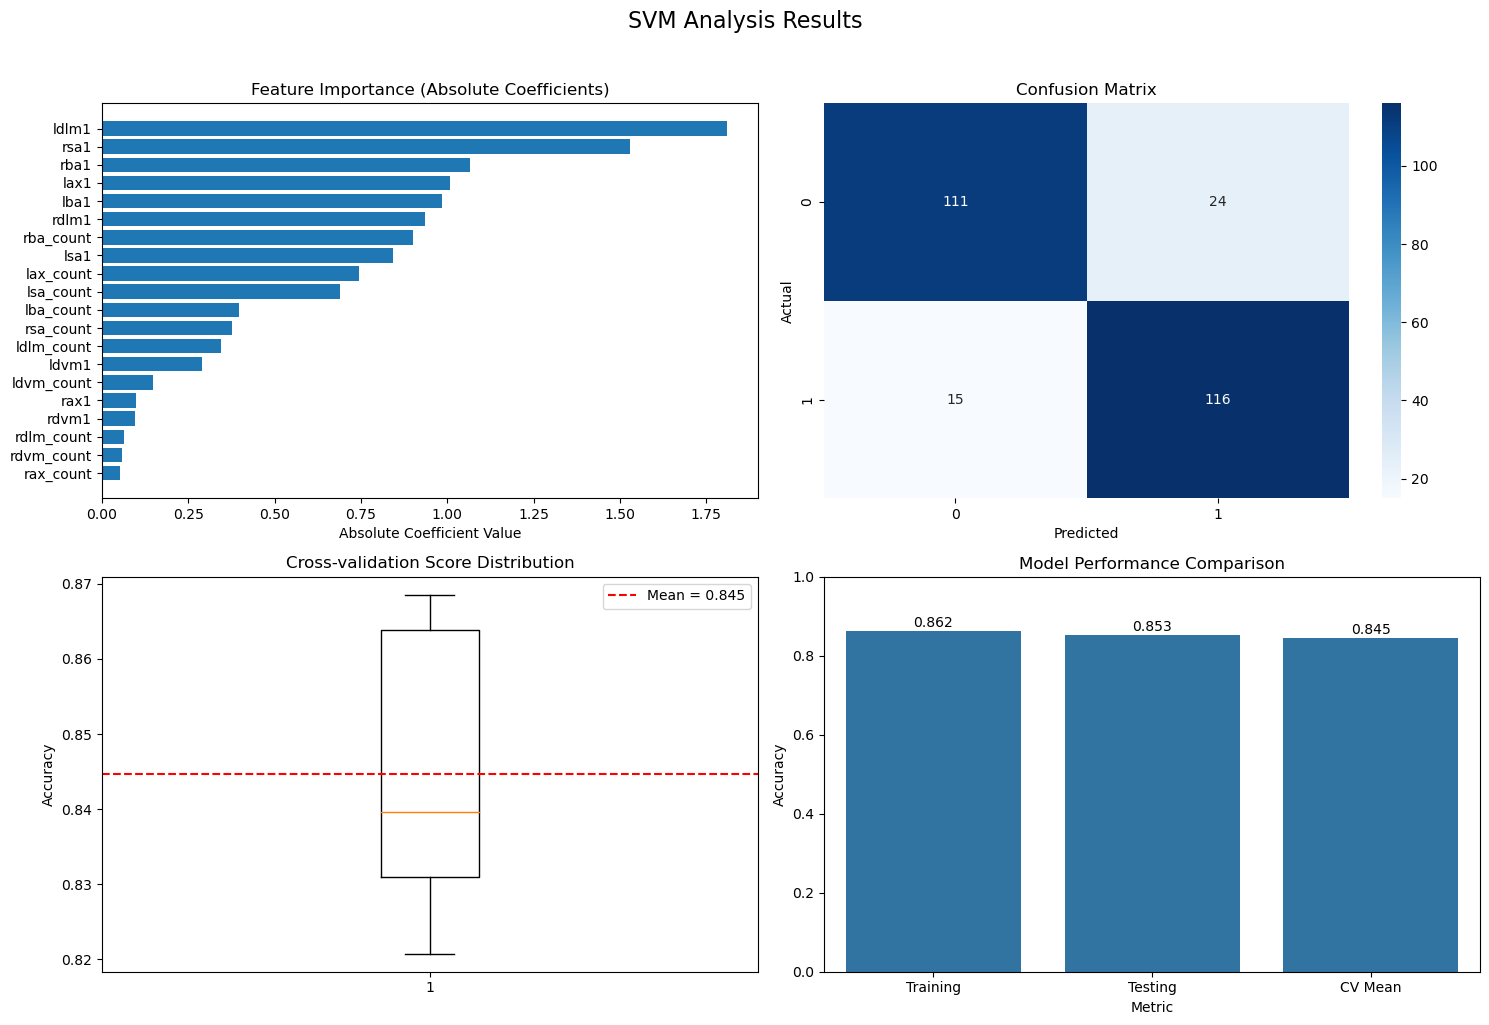

In [21]:
reslin = run_svm_analysis(nona,features,"trial",kernel='linear',C=8)
fig = plot_svm_results(reslin,features)


In [22]:
resrbf = run_svm_analysis(nona,features,"trial",kernel="rbf",C=8)
print(f"The Mean CV Score is: {np.round(np.mean(resrbf['cv_scores']),decimals=4)}")

The Mean CV Score is: 0.9821


How Important are the Features?

X has feature names, but StandardScaler was fitted without feature names


Calculating permutation importance...

Plotting permutation importance...

Calculating and plotting SHAP values...


100%|██████████| 100/100 [03:57<00:00,  2.37s/it]


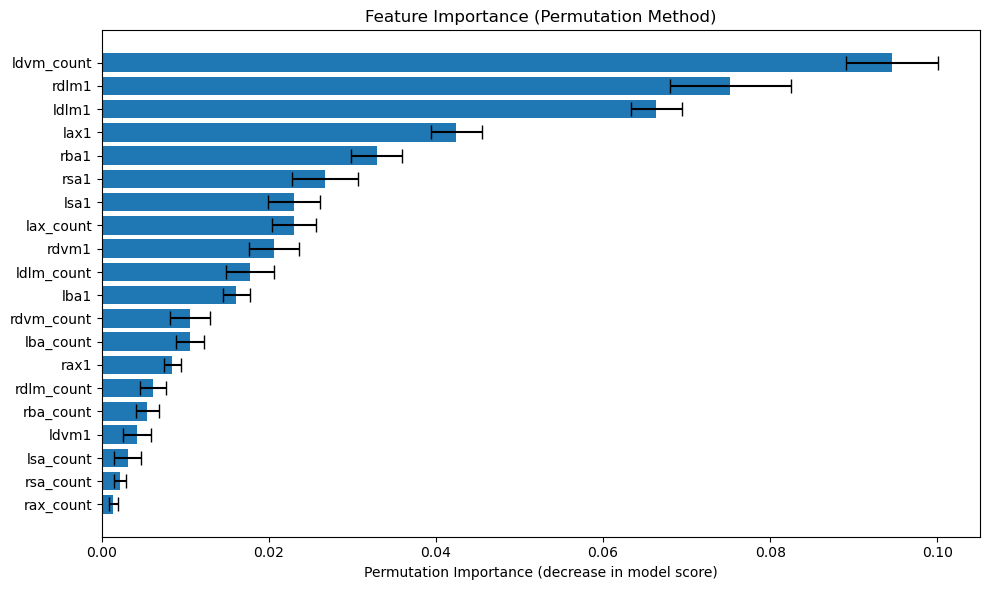

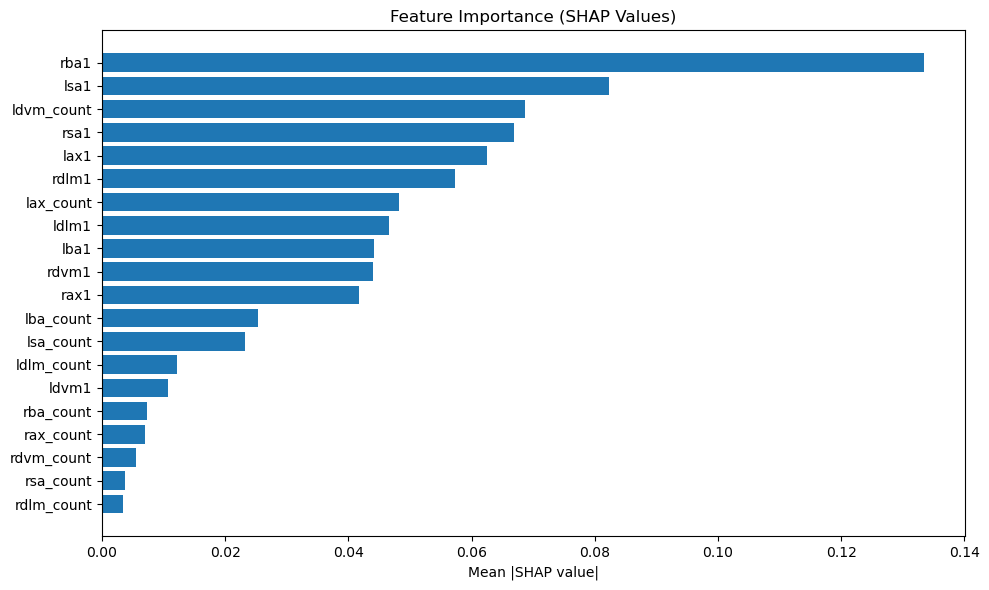

<Figure size 1200x600 with 0 Axes>

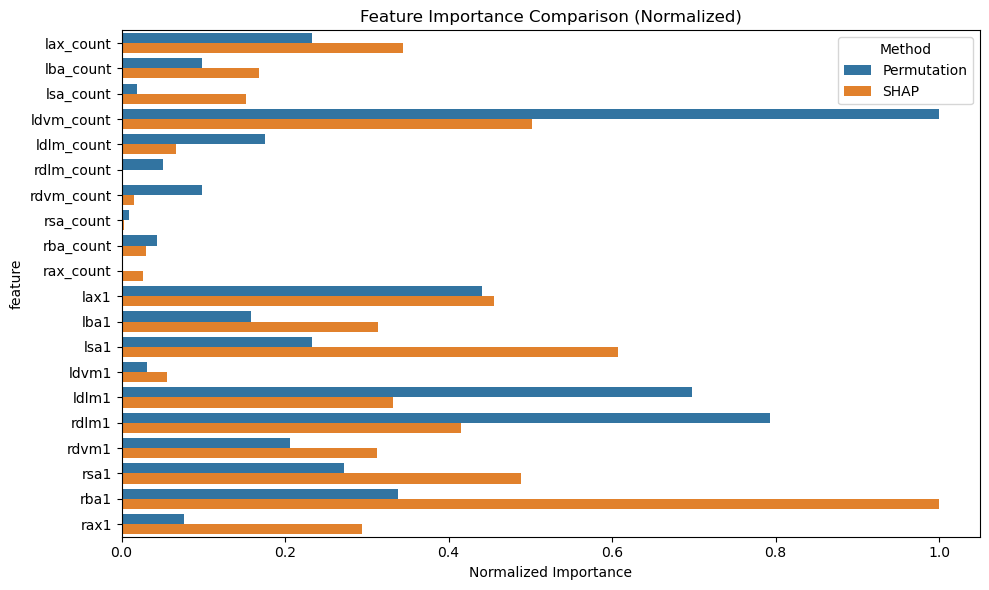

In [23]:
X = resrbf['scaler'].transform(nona[features])
y = Binarizer().fit_transform(nona["trial"].values.reshape(-1,1)).ravel()
rbf_res_dic = analyze_rbf_feature_importance(resrbf['model'], X, y, feature_names=features)

Lets Combine Out the Shap Features for both Boost and SVM RBF

In [24]:
#normalizing each to max importance
rbf_shap_df = rbf_res_dic["shap_importance"].copy()
rbf_shap_df.rename(columns={"importance": "rbf_importance"}, inplace=True)

rbf_shap_df['rbf_importance'] = rbf_shap_df['rbf_importance'] / rbf_shap_df['rbf_importance'].max()

boost_shap_df = shapdf.drop(columns=["mean_abs_shap_normalized"])
boost_shap_df.rename(columns={"mean_abs_shap": "boost_importance"}, inplace=True)
boost_shap_df['boost_importance'] = boost_shap_df['boost_importance'] / boost_shap_df['boost_importance'].max()

boost_shap_df

merged_df = pd.merge(boost_shap_df, rbf_shap_df, on="feature")
merged_df.reset_index(drop=True, inplace=True)
merged_df.to_csv("shapimportance.csv",index=False)